In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pl_bolts.datamodules import MNISTDataModule
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import os

from sklearn.decomposition import FastICA, PCA
from sklearn.metrics import pairwise_distances
import tqdm

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
outputdir = os.path.expanduser("~/data/plots_of_the_day/lpl/fig_toy_models")
outputdir_suppl = os.path.expanduser("~/data/plots_of_the_day/lpl/suppl_fig_losses")

os.makedirs(outputdir, exist_ok=True)
os.makedirs(outputdir_suppl, exist_ok=True)

## Setting up the data generator

In [4]:
B = 1
sigma = 1

In [5]:
# Provides an initial sample of inputs (equally distributed between the two clusters)
def sample_data(N, sigma=1.0):
    x = torch.zeros([N, 2])

    x[:N//2,0] = B
    x[N//2:,0] = -B
    x[:, 1] = sigma*torch.randn(N)
    x[:, 0] += 0.1*torch.randn(N)
    
    labels = torch.tensor([0]*(N//2) + [1]*(N//2))
    
    return x, labels

In [6]:
def next_sequence_element(stim, sigma, labels, noise_probability=0.):
    """
    Generates next element of the stimulus sequence given a minibatch of current stimuli
    Preserves the value of first (x) component with a probability of (1-noise_probability)
    Second (y) component is zero-mean Gaussian noise with standard deviation sigma
    labels is just a record of the x-component (which cluster the stimulus belongs to)
    """

    N = stim.shape[0]
    next_stim = torch.zeros([N, 2])

    next_stim[labels==0, 0] = B
    next_stim[labels==1, 0] = -B
    
    if noise_probability>0:
        noise_transitions = torch.rand(N)<noise_probability
        next_stim[noise_transitions, 0] *= -1
        labels[noise_transitions] = 1 - labels[noise_transitions]
    
    next_stim[:, 1] = sigma*torch.randn(N)
    next_stim[:, 0] += 0.1*torch.randn(N)
    
    return next_stim, labels

#### Some quick data visualization

In [7]:
data, labels = sample_data(100)

In [8]:
def plot_scatter(sigma, xytext, xy, color, suffix):
    num_samples = 20
    data, labels = sample_data(num_samples, sigma)
    plt.figure(figsize=(0.3, 0.25), dpi=300)
    plt.scatter(data[:num_samples//2,0], data[:num_samples//2,1], color='#4477AA', alpha=0.6, s=0.9)
    plt.scatter(data[num_samples//2:,0], data[num_samples//2:,1], color='gray', alpha=0.6, s=0.9)
    plt.xlim(-3, 3)
    plt.ylim(-10, 10)
    plt.xlabel('x')
    plt.ylabel('y')
    sns.despine()
    plt.annotate(r'$\sigma_y={}$'.format(sigma), (2.5, -2.5), fontsize=8)
    plt.axis('off')
    plt.annotate('', xytext=xytext, xy=xy, arrowprops=dict(arrowstyle='->', color=color, lw=0.4, mutation_scale=5))

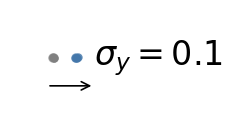

In [9]:
plot_scatter(0.1, xytext=(-2,-10), xy=(3,-10), color='k', suffix='small')

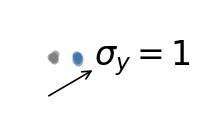

In [10]:
plot_scatter(1, xytext=(-2,-15), xy=(3,-3), color='k', suffix='medium')

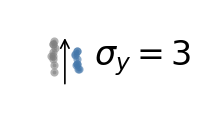

In [11]:
plot_scatter(3, xytext=(0,-12), xy=(0,10), color='k', suffix='large')

## LPL on synthetic data sequence

In [12]:
def hebbian_loss(a):
    a_center = a.mean(dim=0).detach()
    variance = ((a - a_center) ** 2).sum(dim=0) / (a.shape[0] - 1) + 1e-8
    loss = (-torch.log(variance)).mean()

    return loss

def vic_variance_regularizer(a):
    """
    Alternative Hebbian loss - variance regularizer from VICReg
    Bardes, A., Ponce, J., & LeCun, Y. (2021). Vicreg: Variance-invariance-covariance regularization for self-supervised learning. arXiv preprint arXiv:2105.04906
    """
    a_center = a.mean(dim=0).detach()
    variance = ((a - a_center) ** 2).sum(dim=0) / (a.shape[0] - 1) + 1e-8
    loss = (1-torch.sqrt(variance))
    loss[loss<0] = 0

    return loss.mean()

def naive_variance_regularizer(a):
    """
    Alternative push loss without the logarithm, which means no variance-dependent suppression
    """
    a_center = a.mean(dim=0).detach()
    variance = ((a - a_center) ** 2).sum(dim=0) / (a.shape[0] - 1)
    loss = -variance.mean()

    return loss

In [13]:
def trainer(num_steps, batch_size, sigma, noise_p=0., pred_learning=False, hebb_learning=True, use_vic_loss_variant=False, variance_dependent_scaling=True, ojas_rule=False, lr=1e-5, weight_decay=1e-3, return_activity_norms=False):
    net = nn.Linear(2, 1, bias=False)

    if not ojas_rule:
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)
        pred_loss = nn.MSELoss()
    
    x, labels = sample_data(batch_size, sigma)
    
    if return_activity_norms:
        activity_norms = torch.zeros(num_steps)

    for t in range(num_steps):
        y = net(x)
        loss = 0.
        
        new_x, new_labels = next_sequence_element(x, sigma, labels, noise_probability=noise_p)
        y_next = net(new_x)

        if ojas_rule:
            net.weight.data += (lr*y_next*(new_x-y_next*net.weight.data)).mean(dim=0) - lr*weight_decay*net.weight.data
        else:
            if hebb_learning:
                if variance_dependent_scaling:
                    if use_vic_loss_variant:
                        loss += vic_variance_regularizer(y_next)
                    else:
                        loss += hebbian_loss(y_next)
                else:
                    loss += naive_variance_regularizer(y_next)

            if pred_learning:
                loss += pred_loss(y_next, y.detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if return_activity_norms:
            activity_norms[t] = torch.abs(y_next).mean().detach()
        
        x = new_x.clone()
        labels = new_labels.clone()
    
    if return_activity_norms:
        return net.weight.data, activity_norms
    else:
        return net.weight.data

### Different amounts of noise $\sigma_y$

In [14]:
num_reps = 10
num_sigmas = 50

batch_size = 200
weight_decay= 1.5e-1

sigmas = torch.logspace(-2, 2, num_sigmas)

# Cosine of the learned weight matrix with x-axis
oja_cosines = torch.zeros(num_reps, num_sigmas)
pred_off_cosines = torch.zeros(num_reps, num_sigmas)
lpl_cosines = torch.zeros(num_reps, num_sigmas)
naive_varreg_cosines = torch.zeros(num_reps, num_sigmas)
vic_cosines = torch.zeros(num_reps, num_sigmas)

# x-selectivity
oja_selectivity = torch.zeros(num_reps, num_sigmas)
pred_off_selectivity = torch.zeros(num_reps, num_sigmas)
lpl_selectivity = torch.zeros(num_reps, num_sigmas)
naive_varreg_selectivity = torch.zeros(num_reps, num_sigmas)
vic_selectivity = torch.zeros(num_reps, num_sigmas)

for i in range(num_reps):
    for j in tqdm.trange(len(sigmas)):
        sigma = sigmas[j]
        num_steps = max(10000, int(100*sigma))
        val_data, val_labels = sample_data(10000, sigma)

        weight = trainer(num_steps, batch_size, sigma, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay, ojas_rule=True)
        oja_cosines[i, j] = weight[0, 0]/weight[0].norm()
        projected_data = torch.mm(val_data, weight.T)
        oja_selectivity[i, j] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))
        
        weight = trainer(num_steps, batch_size, sigma, pred_learning=False, hebb_learning=True, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay)
        pred_off_cosines[i, j] = weight[0, 0]/weight[0].norm()
        projected_data = torch.mm(val_data, weight.T)
        pred_off_selectivity[i, j] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))
        
        weight = trainer(num_steps, batch_size, sigma, pred_learning=True, hebb_learning=True, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay)
        lpl_cosines[i, j] = weight[0, 0]/weight[0].norm()
        projected_data = torch.mm(val_data, weight.T)
        lpl_selectivity[i, j] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))
        
        weight = trainer(num_steps, batch_size, sigma, pred_learning=True, hebb_learning=True, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay, variance_dependent_scaling=False)
        naive_varreg_cosines[i, j] = weight[0, 0]/weight[0].norm()
        projected_data = torch.mm(val_data, weight.T)
        naive_varreg_selectivity[i, j] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))
        
        weight = trainer(num_steps, batch_size, sigma, pred_learning=True, hebb_learning=True, use_vic_loss_variant=True,lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay)
        vic_cosines[i, j] = weight[0, 0]/weight[0].norm()
        projected_data = torch.mm(val_data, weight.T)
        vic_selectivity[i, j] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))

100%|██████████| 50/50 [11:55<00:00, 14.32s/it]


#### Learned x-Selectivity

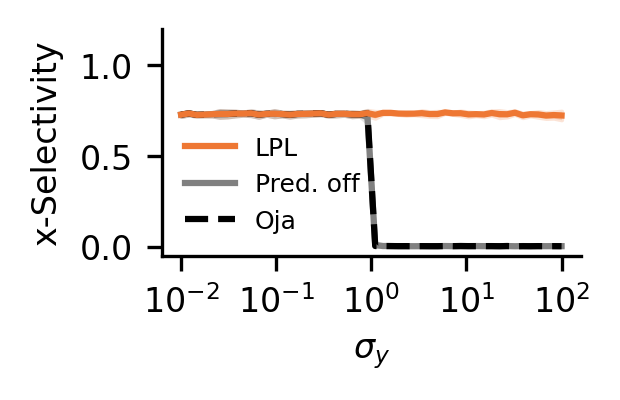

In [15]:
plt.figure(figsize=(1.8, 1), dpi=300, frameon=False)

plt.semilogx(sigmas, torch.abs(lpl_selectivity).mean(dim=0), label='LPL', color='#EE7733', zorder=3)
y = torch.abs(lpl_selectivity).mean(dim=0)
yerr = torch.abs(lpl_selectivity).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color='#EE7733', alpha=0.2)

plt.semilogx(sigmas, torch.abs(pred_off_selectivity).mean(dim=0), label='Pred. off', color='gray', zorder=1)
y = torch.abs(pred_off_selectivity).mean(dim=0)
yerr = torch.abs(pred_off_selectivity).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color='gray', alpha=0.2)

plt.semilogx(sigmas, torch.abs(oja_selectivity).mean(dim=0), label='Oja', color='black', linestyle='--', zorder=2)
y = torch.abs(oja_selectivity).mean(dim=0)
yerr = torch.abs(oja_selectivity).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color='gray', alpha=0.2)

plt.xlabel(r'$\sigma_y$', fontsize=8)
plt.ylabel('x-Selectivity', fontsize=8)
sns.despine()
plt.legend(frameon=False, fontsize=6)
plt.xticks([0.01, 0.1, 1, 10, 100])
# plt.yticks([0.0, 0.5])

plt.ylim(-0.05, 1.2)

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)

plt.savefig(os.path.join(outputdir,'lowD_selectivity.pdf'), bbox_inches='tight', backend='pgf')

#### Alternative measure of selectivity (cosine wrt x-axis)

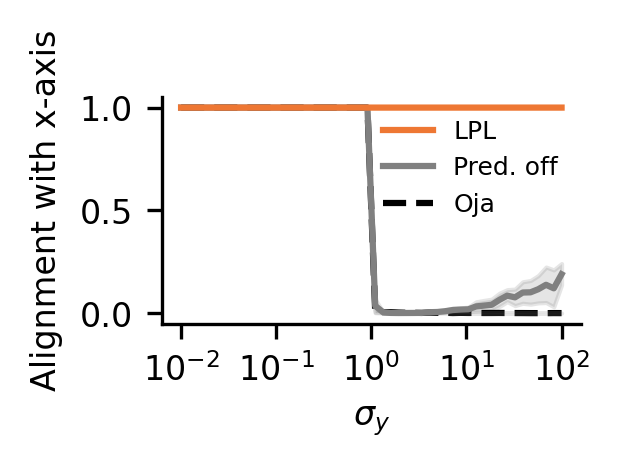

In [16]:
plt.figure(figsize=(1.8, 1), dpi=300, frameon=False)

plt.semilogx(sigmas, torch.abs(lpl_cosines).mean(dim=0), label='LPL', color='#EE7733', zorder=3)
y = torch.abs(lpl_cosines).mean(dim=0)
yerr = torch.abs(lpl_cosines).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color='#EE7733', alpha=0.2)

plt.semilogx(sigmas, torch.abs(pred_off_cosines).mean(dim=0), label='Pred. off', color='gray', zorder=2)
y = torch.abs(pred_off_cosines).mean(dim=0)
yerr = torch.abs(pred_off_cosines).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color='gray', alpha=0.2)

plt.semilogx(sigmas, torch.abs(oja_cosines).mean(dim=0), label='Oja', color='black', linestyle='--', zorder=1)
y = torch.abs(oja_cosines).mean(dim=0)
yerr = torch.abs(oja_cosines).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color='gray', alpha=0.2)

plt.xlabel(r'$\sigma_y$', fontsize=8)
plt.ylabel('Alignment with x-axis', fontsize=8)
sns.despine()
plt.legend(frameon=False, fontsize=6)
plt.xticks([0.01, 0.1, 1, 10, 100])

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)

#### Comparison with other forms of the push loss

In [17]:
idxs = naive_varreg_selectivity[0].isnan()
idxs

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

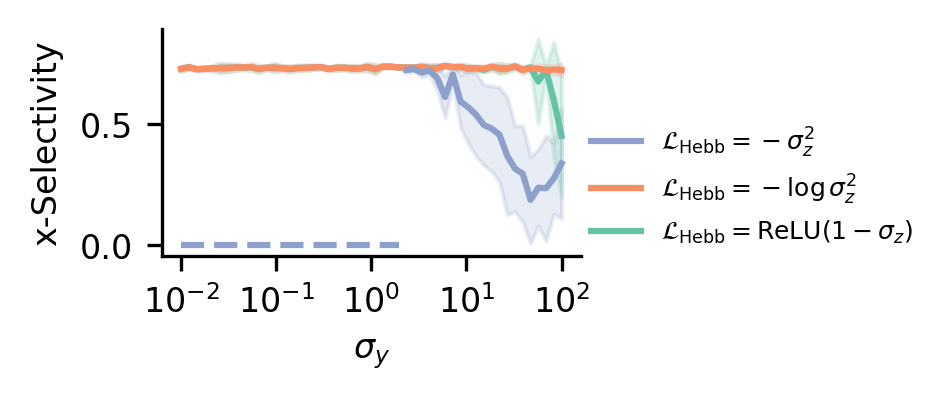

In [18]:
plt.figure(figsize=(1.8, 1.0), dpi=300, frameon=False)

# colors = ['#1b9e77', '#d95f02', '#7570b3']
# colors = ['#0077BB', '#EE7733', '#CC3311']
# colors = ['#4477AA', '#228833', '#EE6677']
colors = ['#8da0cb', '#fc8d62', '#66c2a5']

plt.semilogx(sigmas, torch.abs(naive_varreg_selectivity).mean(dim=0), label=r'$\mathcal{L}_\mathrm{Hebb}=-\sigma_z^2$', color=colors[0], zorder=3)
plt.hlines(0, sigmas[idxs][0], sigmas[idxs][-1], color=colors[0], zorder=3, linestyle='--')
y = torch.abs(naive_varreg_selectivity).mean(dim=0)
yerr = torch.abs(naive_varreg_selectivity).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color=colors[0], alpha=0.2)

plt.semilogx(sigmas, torch.abs(lpl_selectivity).mean(dim=0), label=r'$\mathcal{L}_\mathrm{Hebb}=-\log{\sigma_z^2}$', color=colors[1], zorder=2)
y = torch.abs(lpl_selectivity).mean(dim=0)
yerr = torch.abs(lpl_selectivity).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color=colors[1], alpha=0.2)

plt.semilogx(sigmas, torch.abs(vic_selectivity).mean(dim=0), label=r'$\mathcal{L}_\mathrm{Hebb}=\mathrm{ReLU}(1-\sigma_z)$', color=colors[2], zorder=1)
y = torch.abs(vic_selectivity).mean(dim=0)
yerr = torch.abs(vic_selectivity).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color=colors[2], alpha=0.2)

plt.xlabel(r'$\sigma_y$', fontsize=8)
plt.ylabel('x-Selectivity', fontsize=8)
sns.despine()
plt.legend(frameon=False, fontsize=6, loc=(1,0.))
plt.xticks([0.01, 0.1, 1, 10, 100])

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)

plt.savefig(os.path.join(outputdir_suppl,'lowD_selectivity_suppl_losses.pdf'), bbox_inches='tight')

### Collapsed/runaway activity for a fixed $\sigma_y$ of 1

In [19]:
num_reps = 10

sigma = 1
num_steps = max(10000, int(10*sigma))

batch_size = 200
weight_decay= 1.5e-1

val_data, val_labels = sample_data(10000, sigma)

full_model_weight_norms = torch.zeros(num_reps, num_steps)
naive_model_weight_norms = torch.zeros(num_reps, num_steps)
vic_model_weight_norms = torch.zeros(num_reps, num_steps)
push_only_weight_norms = torch.zeros(num_reps, num_steps)
pull_only_weight_norms = torch.zeros(num_reps, num_steps)

full_model_activity_norms = torch.zeros(num_reps, num_steps)
naive_model_activity_norms = torch.zeros(num_reps, num_steps)
vic_model_activity_norms = torch.zeros(num_reps, num_steps)
push_only_activity_norms = torch.zeros(num_reps, num_steps)
pull_only_activity_norms = torch.zeros(num_reps, num_steps)

full_model_cosines = torch.zeros(num_reps)
naive_model_cosines = torch.zeros(num_reps)
vic_model_cosines = torch.zeros(num_reps)
push_only_cosines = torch.zeros(num_reps)
pull_only_cosines = torch.zeros(num_reps)

full_model_selectivity = torch.zeros(num_reps)
naive_model_selectivity = torch.zeros(num_reps)
vic_model_selectivity = torch.zeros(num_reps)
push_only_selectivity = torch.zeros(num_reps)
pull_only_selectivity = torch.zeros(num_reps)

for i in tqdm.trange(num_reps):

    weight, activity_norms = trainer(num_steps, batch_size, sigma, return_activity_norms=True, pred_learning=True, hebb_learning=True, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay)
    full_model_cosines[i] = weight[0, 0]/weight[0].norm()
    projected_data = torch.mm(val_data, weight.T)
    full_model_activity_norms[i] = activity_norms
    full_model_selectivity[i] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))

    weight, activity_norms = trainer(num_steps, batch_size, sigma, return_activity_norms=True, pred_learning=True, hebb_learning=True, variance_dependent_scaling=False, lr=min(1e-2/sigma, 1e-2), weight_decay=10*weight_decay)
    naive_model_cosines[i] = weight[0, 0]/weight[0].norm()
    projected_data = torch.mm(val_data, weight.T)
    naive_model_activity_norms[i] = activity_norms
    naive_model_selectivity[i] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))

    weight, activity_norms = trainer(num_steps, batch_size, sigma, return_activity_norms=True, pred_learning=True, hebb_learning=True, use_vic_loss_variant=True, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay)
    vic_model_cosines[i] = weight[0, 0]/weight[0].norm()
    projected_data = torch.mm(val_data, weight.T)
    vic_model_activity_norms[i] = activity_norms
    vic_model_selectivity[i] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))

    weight, activity_norms = trainer(num_steps, batch_size, sigma, return_activity_norms=True, pred_learning=False, hebb_learning=True, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay)
    push_only_cosines[i] = weight[0, 0]/weight[0].norm()
    projected_data = torch.mm(val_data, weight.T)
    push_only_activity_norms[i] = activity_norms
    push_only_selectivity[i] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))

    weight, activity_norms = trainer(num_steps, batch_size, sigma, return_activity_norms=True, pred_learning=True, hebb_learning=False, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay)
    pull_only_cosines[i] = weight[0, 0]/weight[0].norm()
    projected_data = torch.mm(val_data, weight.T)
    pull_only_activity_norms[i] = activity_norms
    pull_only_selectivity[i] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))

100%|██████████| 10/10 [02:48<00:00, 16.86s/it]


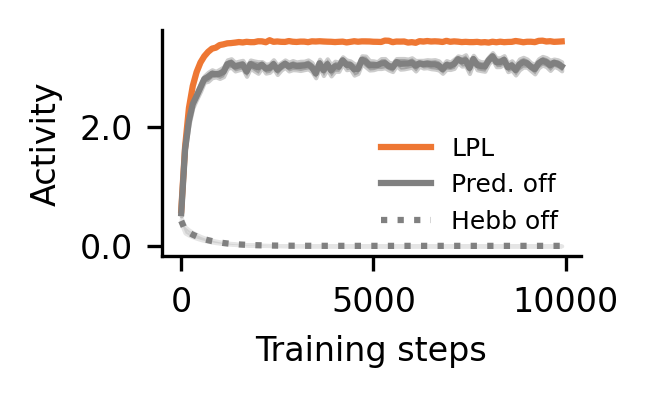

In [20]:
plt.figure(figsize=(1.8, 1), dpi=300)
num_samples = np.stack(full_model_activity_norms).shape[1]
y = np.stack(full_model_activity_norms).mean(axis=0)[::100]
yerr = np.stack(full_model_activity_norms).std(axis=0)[::100]/np.sqrt(10)
plt.plot(list(range(num_samples))[::100], y, color='#EE7733', label='LPL')
plt.fill_between(list(range(num_samples))[::100], y - yerr, y + yerr, color='#EE7733', alpha=0.2)

y = np.stack(push_only_activity_norms).mean(axis=0)[::100]
yerr = np.stack(push_only_activity_norms).std(axis=0)[::100]/np.sqrt(10)
plt.plot(list(range(num_samples))[::100], y, color='gray', label='Pred. off')
plt.fill_between(list(range(num_samples))[::100], y - yerr, y + yerr, color='black', alpha=0.2)

y = np.stack(pull_only_activity_norms).mean(axis=0)[::100]
yerr = np.stack(pull_only_activity_norms).std(axis=0)[::100]/np.sqrt(10)
plt.plot(list(range(num_samples))[::100], y, color='gray', label='Hebb off', linestyle=':')
plt.fill_between(list(range(num_samples))[::100], y - yerr, y + yerr, color='gray', alpha=0.2)

plt.xlabel('Training steps', fontsize=8)
plt.ylabel('Activity', fontsize=8)
plt.legend(frameon=False, fontsize=6)

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.set_yscale('log')
sns.despine()

plt.savefig(os.path.join(outputdir,'lowD_collapse.pdf'), bbox_inches='tight', backend='pgf')

/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


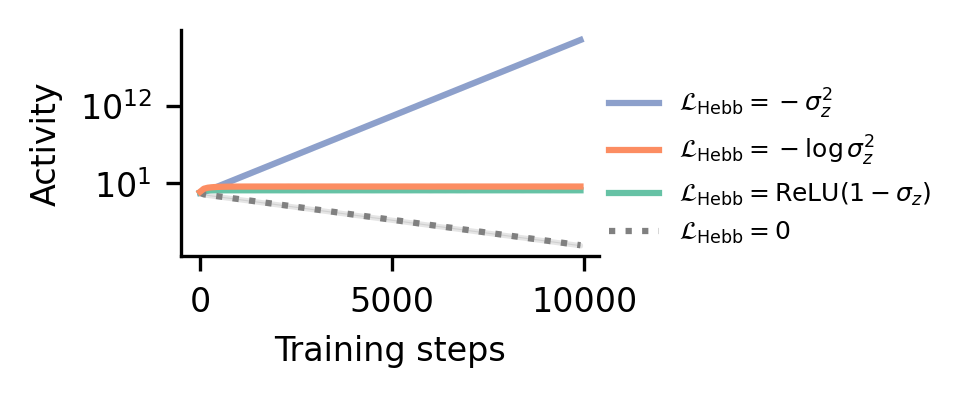

In [21]:
plt.figure(figsize=(1.8, 1.0), dpi=300, frameon=False)
num_samples = np.stack(full_model_activity_norms).shape[1]

y = np.stack(naive_model_activity_norms).mean(axis=0)[::100]
yerr = np.stack(naive_model_activity_norms).std(axis=0)[::100]/np.sqrt(10)
plt.plot(list(range(num_samples))[::100], y, color=colors[0], label=r'$\mathcal{L}_\mathrm{Hebb}=-\sigma_z^2$')
plt.fill_between(list(range(num_samples))[::100], y - yerr, y + yerr, color=colors[0], alpha=0.2)

y = np.stack(full_model_activity_norms).mean(axis=0)[::100]
yerr = np.stack(full_model_activity_norms).std(axis=0)[::100]/np.sqrt(10)
plt.plot(list(range(num_samples))[::100], y, color=colors[1], label=r'$\mathcal{L}_\mathrm{Hebb}=-\log{\sigma_z^2}$', zorder=5)
plt.fill_between(list(range(num_samples))[::100], y - yerr, y + yerr, color=colors[1], alpha=0.2)

y = np.stack(vic_model_activity_norms).mean(axis=0)[::100]
yerr = np.stack(vic_model_activity_norms).std(axis=0)[::100]/np.sqrt(10)
plt.plot(list(range(num_samples))[::100], y, color=colors[2], label=r'$\mathcal{L}_\mathrm{Hebb}=\mathrm{ReLU}(1-\sigma_z)$')
plt.fill_between(list(range(num_samples))[::100], y - yerr, y + yerr, color=colors[2], alpha=0.2)

y = np.stack(pull_only_activity_norms).mean(axis=0)[::100]
yerr = np.stack(pull_only_activity_norms).std(axis=0)[::100]/np.sqrt(10)
plt.plot(list(range(num_samples))[::100], y, color='gray', label=r'$\mathcal{L}_\mathrm{Hebb}=0$', linestyle=':')
plt.fill_between(list(range(num_samples))[::100], y - yerr, y + yerr, color='gray', alpha=0.2)


plt.xlabel('Training steps', fontsize=8)
plt.ylabel('Activity', fontsize=8)
plt.legend(frameon=False, fontsize=6, loc=(1,0.))

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.set_yscale('log')

# plt.yticks([10, 1e11, 1e22])

sns.despine()

plt.savefig(os.path.join(outputdir_suppl,'lowD_divergence_suppl.pdf'), bbox_inches='tight')

## Robustness to noisy inter-cluster transitions

### Selectivity for different probabilities of noisy transitions with fixed $\sigma_y$ of 1

In [22]:
num_reps = 10
num_probs = 50

sigma = 1
batch_size = 200
weight_decay= 1.5e-1

probs = torch.linspace(0, 1, num_probs)

lpl_cosines = torch.zeros(num_reps, num_probs)
lpl_selectivity = torch.zeros(num_reps, num_probs)

for i in range(num_reps):
    for j in tqdm.trange(len(probs)):
        num_steps = max(10000, int(100*sigma))
                
        weight = trainer(num_steps, batch_size, sigma=sigma, noise_p=probs[j], pred_learning=True, hebb_learning=True, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay)
        lpl_cosines[i, j] = weight[0, 0]/weight[0].norm()
        projected_data = torch.mm(val_data, weight.T)
        lpl_selectivity[i, j] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))

100%|██████████| 50/50 [03:32<00:00,  4.24s/it]


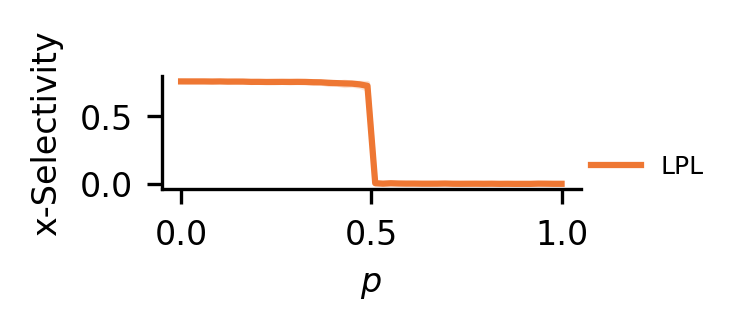

In [23]:
plt.figure(figsize=(1.8, 0.5), dpi=300, frameon=False)

plt.plot(probs, torch.abs(lpl_selectivity).mean(dim=0), label='LPL', color='#EE7733', zorder=3)
y = torch.abs(lpl_selectivity).mean(dim=0)
yerr = torch.abs(lpl_selectivity).std(dim=0)
plt.fill_between(probs, y - yerr, y + yerr, color='#EE7733', alpha=0.2)

plt.xlabel('$p$', fontsize=8)
plt.ylabel('x-Selectivity', fontsize=8)
sns.despine()
plt.legend(frameon=False, fontsize=6, loc=(1,0.))
# plt.xticks([0.01, 0.1, 1, 10, 100])

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)

plt.savefig(os.path.join(outputdir,'lowD_robustness.pdf'), bbox_inches='tight')

### Selectivity for noisy transition probability of 0.2 for different $\sigma_y$

In [42]:
num_reps = 10
num_sigmas = 50

batch_size = 200
weight_decay= 1.5e-1

noise = 0.2

sigmas = torch.logspace(-2, 2, num_sigmas)

oja_cosines = torch.zeros(num_reps, num_sigmas)
pred_off_cosines = torch.zeros(num_reps, num_sigmas)
lpl_cosines = torch.zeros(num_reps, num_sigmas)
bad_vireg_cosines = torch.zeros(num_reps, num_sigmas)
vic_cosines = torch.zeros(num_reps, num_sigmas)

oja_selectivity = torch.zeros(num_reps, num_sigmas)
pred_off_selectivity = torch.zeros(num_reps, num_sigmas)
lpl_selectivity = torch.zeros(num_reps, num_sigmas)
bad_vireg_selectivity = torch.zeros(num_reps, num_sigmas)
vic_selectivity = torch.zeros(num_reps, num_sigmas)

for i in range(num_reps):
    for j in tqdm.trange(len(sigmas)):
        sigma = sigmas[j]
        num_steps = max(10000, int(100*sigma))
        val_data, val_labels = sample_data(10000, sigma)

        weight = trainer(num_steps, batch_size, sigma, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay, ojas_rule=True, noise_p=noise)
        oja_cosines[i, j] = weight[0, 0]/weight[0].norm()
        projected_data = torch.mm(val_data, weight.T)
        oja_selectivity[i, j] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))
        
        weight = trainer(num_steps, batch_size, sigma, pred_learning=False, hebb_learning=True, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay, noise_p=noise)
        pred_off_cosines[i, j] = weight[0, 0]/weight[0].norm()
        projected_data = torch.mm(val_data, weight.T)
        pred_off_selectivity[i, j] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))
        
        weight = trainer(num_steps, batch_size, sigma, pred_learning=True, hebb_learning=True, lr=min(1e-2/sigma, 1e-2), weight_decay=weight_decay, noise_p=noise)
        lpl_cosines[i, j] = weight[0, 0]/weight[0].norm()
        projected_data = torch.mm(val_data, weight.T)
        lpl_selectivity[i, j] = (projected_data[val_labels==0].mean() - projected_data[val_labels==1].mean())/(torch.max(projected_data) - torch.min(projected_data))

100%|██████████| 50/50 [08:11<00:00,  9.84s/it]


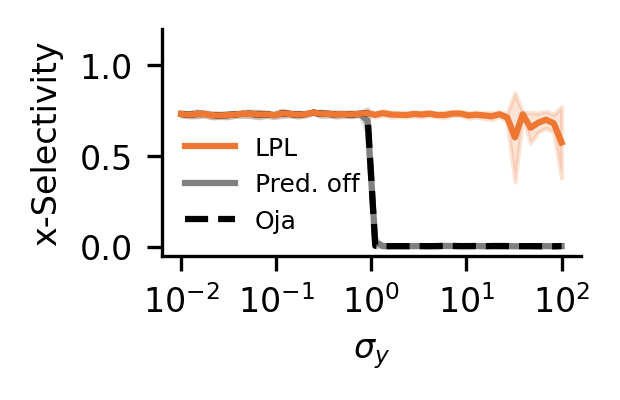

In [43]:
plt.figure(figsize=(1.8, 1), dpi=300, frameon=False)

plt.semilogx(sigmas, torch.abs(lpl_selectivity).mean(dim=0), label='LPL', color='#EE7733', zorder=3)
y = torch.abs(lpl_selectivity).mean(dim=0)
yerr = torch.abs(lpl_selectivity).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color='#EE7733', alpha=0.2)

plt.semilogx(sigmas, torch.abs(pred_off_selectivity).mean(dim=0), label='Pred. off', color='gray', zorder=1)
y = torch.abs(pred_off_selectivity).mean(dim=0)
yerr = torch.abs(pred_off_selectivity).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color='gray', alpha=0.2)

plt.semilogx(sigmas, torch.abs(oja_selectivity).mean(dim=0), label='Oja', color='black', linestyle='--', zorder=2)
y = torch.abs(oja_selectivity).mean(dim=0)
yerr = torch.abs(oja_selectivity).std(dim=0)
plt.fill_between(sigmas, y - yerr, y + yerr, color='gray', alpha=0.2)

plt.xlabel(r'$\sigma_y$', fontsize=8)
plt.ylabel('x-Selectivity', fontsize=8)
sns.despine()
plt.legend(frameon=False, fontsize=6)
plt.xticks([0.01, 0.1, 1, 10, 100])
# plt.yticks([0.0, 0.5])

plt.ylim(-0.05, 1.2)

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)

plt.savefig(os.path.join(outputdir,'lowD_selectivity_noisy.pdf'), bbox_inches='tight', backend='pgf')